In [1]:
using Plots
using Statistics
using LinearAlgebra
using Distributions
import SymPy

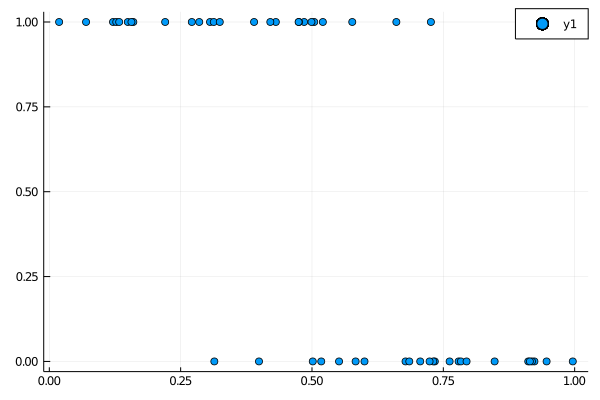

In [2]:
# ∫_0^1 step(a, u) du

f = (a, u) -> a < u ? 1.0 : 0.0

n = 50
x = rand(n)
u = rand(n)
y = f.(x, u)

scatter(x, y)

In [3]:
estimate = mean(y)
estimate, (x .- 0.5)\(y .- estimate)

(0.52, -1.3666346883469884)

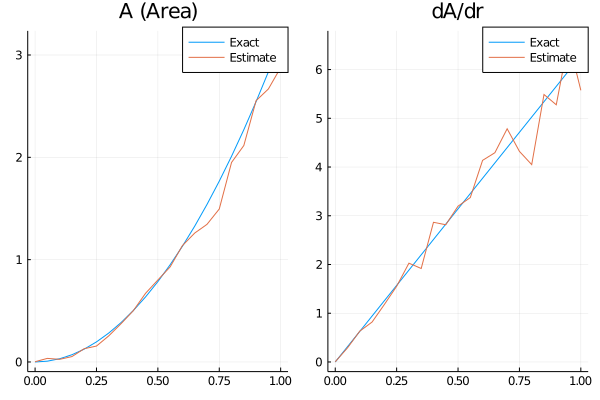

In [4]:
# The area of a circle

f = (r, u0, u1) -> u0^2 + u1^2 < r^2 ? 1.0 : 0.0

function circle_area(r, dr)
    n = 1000
    max = r + dr
    x = rand(Cosine(r, dr), n)
    u_dist = Uniform(-max, max)
    u0 = rand(u_dist, n)
    u1 = rand(u_dist, n)
    y = f.(x, u0, u1) .* (2 * max)^2
    estimate = [ones(n) (x .- r) (x .- r).^2] \ y
    [[pi * r^2; 2 * pi * r; 2 * pi] estimate]
end

rs = 0:0.05:1
values = cat(dims=3, circle_area.(rs, 0.5)...)

l = ["Exact" "Estimate"]
area = plot(rs, values[1,:,:]', title="A (Area)", label=l)
slope = plot(rs, values[2,:,:]', title="dA/dr", label=l)
plot(area, slope)

In [7]:
function fit_integral(f, x_dist, y_dist, n, degrees=1)
    xs = rand(x_dist, n)
    ys = rand(y_dist, n)
    y_offs = ys .- mean(y_dist)
    zs = f.(xs, ys)
    # FIXME
    o_y = Diagonal(1 ./ pdf.(y_dist, ys))
    o_xy = Diagonal(1 ./ pdf.(x_dist, xs)) * o_y
    factors = hcat([y_offs .^ power ./ factorial(power) for power in 0:degrees]...)
    return inv(factors' * o_y * factors) * factors' * o_xy * zs
end

function plot_fit_vs_exact(f, x_dist, y_dists, n, degrees=1)
    x, y = SymPy.symbols("x y")
    F = SymPy.integrate(f(x, y), (x, minimum(x_dist), maximum(x_dist)))
    F_prime = SymPy.diff(F, y)

    estimate = hcat([
        vcat([mean(y_dist)], fit_integral(f, x_dist, y_dist, n, degrees))
        for y_dist in y_dists
    ]...)
    
    ys = estimate[1,:]
    min_y, max_y = extrema(ys)
    F_plot = plot(ys, estimate[2,:], title="F vs y", label="Estimate")
    plot!(F_plot, F, min_y, max_y, label="Exact")
    F_prime_plot = plot(ys, estimate[3,:], title="dF/dy vs y", label="Estimate")
    plot!(F_prime_plot, F_prime, min_y, max_y, label="Exact")
    
    return plot(F_plot, F_prime_plot)
end

plot_fit_vs_exact (generic function with 2 methods)

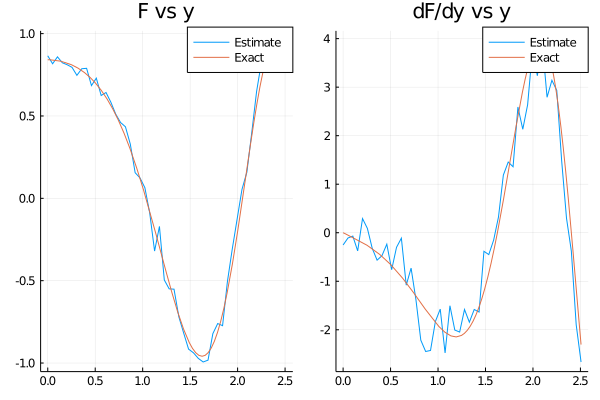

In [8]:
plot_fit_vs_exact(
    (x, y) -> cos(y^2 + x), # f
    truncated(Normal(0.5), 0, 1), # integration domain
    Cosine.(LinRange(0, sqrt(2 * pi), 50), 0.25), # function domain
    50, # samples per point
    2, # degree of estimate (quadratic)
)